## Anwendung aus der Messtechnik: Baseline Fit

In spektrometrischen Anwendungen der Messtechnik hat man oft das Problem, dass die sogenannte Baseline (Untergrund) der Messung unbekannt ist. In der Darstellung unten sehen Sie eine typische Situation:

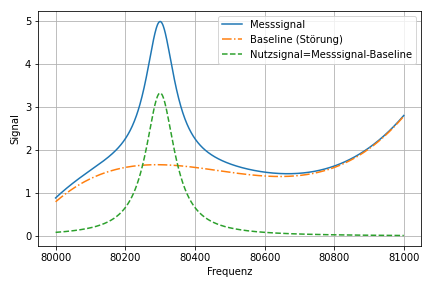

Für die Interpretation des physikalischen Vorgangs ist man nur am Peak (grün) interessiert. Die Rohsignale entsprechen jedoch der blauen Kurve. Das Baselinesignal (orange) ist die Folge von Hintergrundprozessen oder Eigenschaften des Messgerätes und sollte diskriminiert werden. Die folgende Anleitung zeigt Ihnen, wie das mit Hilfe der Ausgleichsrechnung gelingt.

### Beschreibung des Untergrundes (Baseline)

Wir gehen davon aus, dass sich der Untergrund durch ein unbekanntes **Polynom 3. Grades** beschreiben lässt, welches **additiv** zum eigentlichen **Peak der Resonanz** dazu kommt. Damit können wir die Messdaten durch eine *lineare* Kombination von Funktionsansätzen fitten.

### Lorentz-Shape einer Resonaz

Die Systemreaktion wird mit Hilfe der Lorentz-Shape $l(x^\prime)$ beschrieben:

$$l(x^\prime) = \frac{1}{1+(x^\prime)^2},\quad x^\prime = \frac{x-x_0}{s_0/2}.$$

wobei $x_0$ die Resonanzfrequenz und $s_0$ die Breite des Peaks bezeichnen. In vielen Anwendungen ist die Resonanzfreqeunz, also $x_0$ zum vornherein bekannt, aber nicht der Wert von $s_0$. Wenn die Breite $s_0$ aus den Messdaten bestimmt werden muss, wird die Problemstellung *nichtlinear*. 

Deshalb gehen wir hier von einer **bekannten** Breite $s_0 = 100$ aus, die Resonanz befinde sich bei $x_0 = 80.3\cdot 10^3$. Unbekannt ist jedoch die Amplitude des Peaks, d.h. die multiplikative Konstante vor $l(x^\prime)$.

### Rauschenanteil

Im allgemeinen wird die Aufgabe erschwert durch Rauschen im Messsignal, d.h. realistische Daten sehen folgendermassen aus:

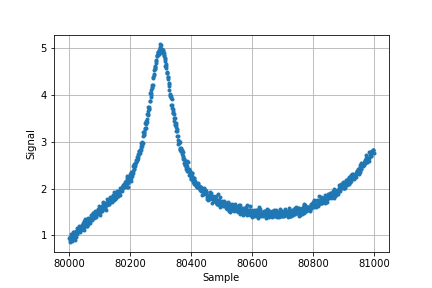

Sie finden diese Daten im Downloadbereich als "data.txt". Eingelesen werden diese Werte via: 
```PYTHON
import numpy as np
np.loadtxt('data.txt')
```
resp. unter Matlab:

```OCTAVE
load('data.txt')
```

## Auftrag 2

### Aufgabe 1: Separation von Lorentz-Peak und Untergrund

- Bestimmen Sie die Systemmatrix $A$ für das lineare Ausgleichsproblem zur Separation des Untergrundes.

- Berechnen Sie die Lösung des Ausgleichsproblems mit folgenden Varianten:

    - Mit der Normalengleichung via $A^T A$
      
      **Bemerkung:** Benutzen Sie hier **alle** gelernten Ansätze (LR, Cholesky, QR)! Sie werden sehen, dass die Matrix so schlecht konditioniert ist, dass nur mit QR eine halbwegs brauchbare Lösung berechnet werden kann!
    
    - Mit der QR-Zerlegung der Matrix $A$ direkt
    
  Bestimmen Sie die Kondition der jeweiligen Matrix und geben Sie einen Kommentar ab, was diese Werte über die erwarte numerische Genauigkeit aussagen.
  
- Stellen Sie den Lorentz-Peak als Funktion mit der gefitteten Amplitude graphisch dar, zusammen mit den verrauschten Daten von welchen Sie den Untergrund *abziehen*.

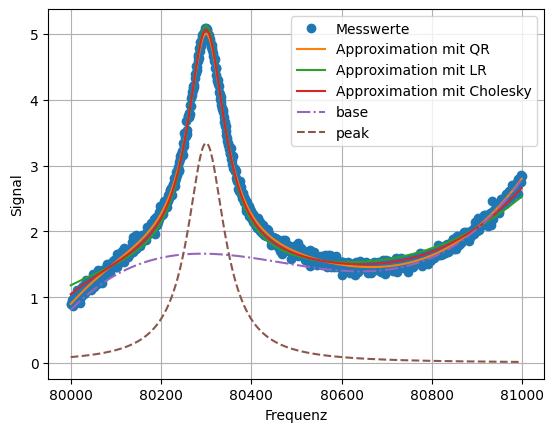

1.0641705171237494e+35
1.443309851649395e+22
1.5121722093950894e+22


In [49]:
import sys, os
from matplotlib.pylab import cholesky
import numpy as np
import matplotlib.pyplot as plt
import numerik_functions as nf  # Importiert numerik_functions.py als nf
from scipy.linalg import solve_triangular,lu,lu_solve


s0=100
x0 =80300

def A1(x):
    xl = ((x - x0)*2) / (s0)
    y_m0= 1 / (1 + xl**2)
    return y_m0

# @Jonny, Ivo: Das mönder evt. uskommentiere zum's File lese
#path_act  = os.getcwd()
#path = os.path.join(path_act, 'praktikum5\data.txt')

data = np.genfromtxt('data.txt')
t = data[:,0] 
n = len(t)        
y_m = data[:,1]    

# Generate Matrix A
A = np.zeros((n,5))



for i in range(0, len(t)):
    A[i] =  [A1(t[i]), 1, t[i], t[i]**2, t[i]**3]


# QR Decomposition
Q,R = np.linalg.qr(A)

# Solve liner system with QR
y_num =  np.dot(Q.T, y_m)
alpha = solve_triangular(R, y_num, trans=0, lower=False, unit_diagonal=False, overwrite_b=False, check_finite=True)


# Solve linear system with LR
b=y_m
ATA = np.dot(A.T, A)
ATb = np.dot(A.T, b)
alphalr = np.linalg.solve(ATA, ATb)


#Cholesky
L = np.linalg.cholesky(ATA)
y = np.linalg.solve(L, ATb)
alphacy = np.linalg.solve(L.T, y)

# define zero Vectors
y_m1 = np.zeros(len(t))
y_mLR = np.zeros(len(t))
y_mcy = np.zeros(len(t))
base = np.zeros(len(t))
peak = np.zeros(len(t))
back = np.zeros(len(t))

# Create data Vectors from calculated coefficients
for i in range(0, len(t)):
    y_m1[i] = alpha[0]*A1(t[i]) + alpha[1] + alpha[2]*t[i] + alpha[3]*t[i]**2 + alpha[4]*t[i]**3
    y_mLR[i] = alphalr[0]*A1(t[i]) + alphalr[1] + alphalr[2]*t[i] + alphalr[3]*t[i]**2 + alphalr[4]*t[i]**3
    y_mcy[i] = alphacy[0]*A1(t[i]) + alphacy[1] + alphacy[2]*t[i] + alphacy[3]*t[i]**2 + alphacy[4]*t[i]**3
    base[i] = alpha[1] + alpha[2]*t[i] +  alpha[3]*t[i]**2 + alpha[4]*t[i]**3
    peak[i] = alpha[0]*A1(t[i])
    #back[i] = alpha[0]*A0(t[i]) - alpha[1] - alpha[2]*t[i] - alpha[3]*t[i]**2 - alpha[4]*t[i]**3


plt.plot(t,y_m,'o', label='Messwerte')
plt.plot(t,y_m1,'-', label='Approximation mit QR')
plt.plot(t,y_mLR,'-', label='Approximation mit LR')
plt.plot(t,y_mcy,'-', label='Approximation mit Cholesky')
plt.plot(t,base,'-.', label ='base')
plt.plot(t,peak,'--',label='peak')
plt.xlabel('Frequenz')
plt.ylabel('Signal')
plt.legend()
plt.grid()
plt.show()




# Conditions of the different approaches

# Condition of LR Solving
print(np.linalg.cond(ATA))
# Condiiton of QR Solving
print(np.linalg.cond(R))
# The QR Solving Method comes up with the lowest condition of the Solving Matrix

# Condition of Cholseky Solving
print(np.linalg.cond(L))



### Aufgabe 2: Verbesserung der Numerik (optional)

- Verbessern Sie die Kondition der beteiligten Matrizen, indem Sie die $x$-Achse auf das Intervall $[0,1]$ skalieren.

- Wiederholen Sie die Berechnungen mit den skalierten, verschobenen x-Werten und dokumentieren Sie die Unterschiede zum unskalierten Fall.